#### Pandas Development and Testing - Part 96

This notebook covers pandas testing practices, plotting backends, and Parquet storage format.

##### Test-Driven Development in Pandas

Pandas strongly encourages test-driven development (TDD), which follows this process:

1. Write an initially failing automated test case that defines a desired improvement or new function
2. Produce the minimum amount of code to pass that test
3. Refactor the code to meet quality standards

Pandas uses pytest and the extensions in numpy.testing for its testing framework.

### Writing Tests

All tests should go into the `tests` subdirectory of the specific package. Here's an example of a proper test:

In [1]:
# Example of a test for the pivot function
import pandas as pd
from pandas._testing import assert_frame_equal

def test_pivot():
    data = {
        'index': ['A', 'B', 'C', 'C', 'B', 'A'],
        'columns': ['One', 'One', 'One', 'Two', 'Two', 'Two'],
        'values': [1., 2., 3., 3., 2., 1.]
    }
    
    frame = pd.DataFrame(data)
    pivoted = frame.pivot(index='index', columns='columns', values='values')
    
    expected = pd.DataFrame({
        'One': {'A': 1., 'B': 2., 'C': 3.},
        'Two': {'A': 1., 'B': 2., 'C': 3.}
    })
    
    assert_frame_equal(pivoted, expected)

### Transitioning to pytest

Pandas is moving from a class-based testing approach to a more functional style using pytest:

In [2]:
# Old class-based style
class TestReallyCoolFeature:
    def test_something(self):
        pass

# New functional style with pytest
def test_really_cool_feature():
    pass

### Using pytest Features

Pytest offers several powerful features for testing:

In [4]:
import pytest
import pandas as pd
import numpy as np

# Using parametrize to test multiple cases
@pytest.mark.parametrize(
    "test_input,expected",
    [
        (pd.Series([1, 2, 3]), 6),
        (pd.Series([10, 20, 30]), 60),
        pytest.param(pd.Series([-1, -2, -3]), -6, marks=pytest.mark.xfail),
    ]
)
def test_series_sum(test_input, expected):
    assert test_input.sum() == expected

# Using fixtures for object construction
@pytest.fixture
def sample_dataframe():
    return pd.DataFrame({
        'A': [1, 2, 3],
        'B': ['a', 'b', 'c']
    })

def test_dataframe_shape(sample_dataframe):
    assert sample_dataframe.shape == (3, 2)

##### Plotting Backends

Starting in pandas 0.25, you can use third-party plotting backends instead of the default Matplotlib backend:

<Axes: title={'center': 'Simple Bar Plot'}>

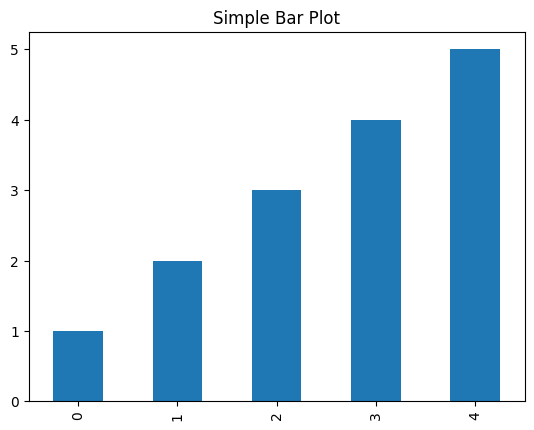

In [5]:
import pandas as pd

# The default backend is matplotlib
pd.set_option('plotting.backend', 'matplotlib')

# Example of switching to a different backend (if installed)
# pd.set_option('plotting.backend', 'plotly')

# Create a simple plot with the current backend
s = pd.Series([1, 2, 3, 4, 5])
s.plot(kind='bar', title='Simple Bar Plot')

### Implementing a Custom Plotting Backend

Libraries can implement custom plotting backends by using entry points with the key `pandas_plotting_backends`. For example:

```python
# in setup.py
setup(
    ...,
    entry_points={
        "pandas_plotting_backends": [
            "matplotlib = pandas:plotting._matplotlib",
        ],
    },
)
```

##### Storing pandas DataFrames in Apache Parquet Format

Apache Parquet is a columnar storage format that provides efficient storage and retrieval of data. Pandas can store DataFrames in Parquet format with metadata that allows for faithful reconstruction.

### Parquet Metadata Structure

The metadata stored in Parquet files for pandas DataFrames includes:

```json
{
  'index_columns': [<descr0>, <descr1>, ...],
  'column_indexes': [<ci0>, <ci1>, ..., <ciN>],
  'columns': [<c0>, <c1>, ...],
  'pandas_version': $VERSION,
  'creator': {
    'library': $LIBRARY,
    'version': $LIBRARY_VERSION
  }
}
```

Each column's metadata is stored as:

```json
{
  'name': column_name,
  'field_name': parquet_column_name,
  'pandas_type': pandas_type,
  'numpy_type': numpy_type,
  'metadata': metadata
}
```

### Index Metadata

RangeIndex can be stored as metadata only, without requiring serialization:

```python
index = pd.RangeIndex(0, 10, 2)
{
  'kind': 'range',
  'name': index.name,
  'start': index.start,
  'stop': index.stop,
  'step': index.step
}
```

Other index types must be serialized as data columns along with the DataFrame columns.

### Column Type Mapping

The `pandas_type` field in the column metadata maps to these values:

- Boolean: 'bool'
- Integers: 'int8', 'int16', 'int32', 'int64', 'uint8', 'uint16', 'uint32', 'uint64'
- Floats: 'float16', 'float32', 'float64'
- Date and Time Types: 'datetime', 'datetimetz', 'timedelta'
- String: 'unicode', 'bytes'
- Categorical: 'categorical'

### Example: Reading and Writing Parquet Files

In [6]:
import pandas as pd
import numpy as np

# Create a sample DataFrame with different data types
df = pd.DataFrame({
    'A': [1, 2, 3, 4, 5],
    'B': ['a', 'b', 'c', 'd', 'e'],
    'C': [1.1, 2.2, 3.3, 4.4, 5.5],
    'D': [True, False, True, False, True],
    'E': pd.date_range('20210101', periods=5),
    'F': pd.Categorical(['cat', 'dog', 'cat', 'dog', 'cat'])
})

# Set a custom index
df.set_index('A', inplace=True)

# Display the DataFrame
print("Original DataFrame:")
print(df)

# Write to Parquet format
# df.to_parquet('example.parquet')

# Read from Parquet format
# df_read = pd.read_parquet('example.parquet')
# print("\nDataFrame read from Parquet:")
# print(df_read)

# Note: The actual read/write operations are commented out
# as they would create files in the filesystem

Original DataFrame:
   B    C      D          E    F
A                               
1  a  1.1   True 2021-01-01  cat
2  b  2.2  False 2021-01-02  dog
3  c  3.3   True 2021-01-03  cat
4  d  4.4  False 2021-01-04  dog
5  e  5.5   True 2021-01-05  cat
